In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Library

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import tensorflow as tf
from keras import layers, models

# Image Pre-Processing

In [6]:
image_dir = Path('/content/drive/MyDrive/_Semester 5/Capstone Project/face/train')

print(os.listdir(image_dir))

['Triangle', 'Square', 'Round', 'Diamond', 'Heart', 'Oblong', 'Oval']


In [ ]:
classess = ['Diamond','Heart','Oblong','Oval','Round','Square','Triangle']

In [7]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3)

train_images = img_generator.flow_from_directory(
    image_dir,
    target_size=(200, 200),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_images = img_generator.flow_from_directory(
    image_dir,
    target_size=(200, 200),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='validation'
)

Found 1461 images belonging to 7 classes.
Found 623 images belonging to 7 classes.


# Modeling

In [ ]:
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(64, (2, 3), activation='relu', input_shape=(200 , 200, 3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(32, (2, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(32, (2, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2)))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(7, activation='softmax'))

model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
            loss='categorical_crossentropy', 
            metrics = ['accuracy'])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 199, 198, 64)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 97, 32)        12320     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 46, 32)        6176      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 23, 32)       0

# Training & Save Model

In [ ]:
history = model_cnn.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('./model.h5', save_best_only=True, save_weights_only=True)
    ]
)

Epoch 1/10
46/46 [==============================] - 513s 11s/step - loss: 1.9549 - accuracy: 0.1403 - val_loss: 1.9418 - val_accuracy: 0.1734
Epoch 2/10
46/46 [==============================] - 128s 3s/step - loss: 1.9070 - accuracy: 0.2156 - val_loss: 1.9271 - val_accuracy: 0.1653
Epoch 3/10
46/46 [==============================] - 130s 3s/step - loss: 1.7626 - accuracy: 0.3149 - val_loss: 1.9186 - val_accuracy: 0.2183
Epoch 4/10
46/46 [==============================] - 131s 3s/step - loss: 1.5788 - accuracy: 0.4018 - val_loss: 2.0133 - val_accuracy: 0.2199
Epoch 5/10
46/46 [==============================] - 132s 3s/step - loss: 1.3361 - accuracy: 0.5079 - val_loss: 2.1088 - val_accuracy: 0.2183
Epoch 6/10
46/46 [==============================] - 131s 3s/step - loss: 1.0769 - accuracy: 0.6242 - val_loss: 2.3976 - val_accuracy: 0.2039
Epoch 7/10
46/46 [==============================] - 156s 3s/step - loss: 0.8398 - accuracy: 0.7070 - val_loss: 2.8827 - val_accuracy: 0.1878
Epoch 8/10
4

In [ ]:
model_cnn.load_weights('./model.h5')

In [ ]:
results = model_cnn.evaluate(train_images, verbose=0)
print("Loss: {:.4f}".format(results[0]))
print("Accuracy: {:.2f} %".format(results[1] * 100))

Loss: 1.6278
Accuracy: 37.71 %


# Test

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Ambil Gambar';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[-1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
except Exception as err:
  print(str(err))

<IPython.core.display.Javascript object>

Saved to photo.jpg


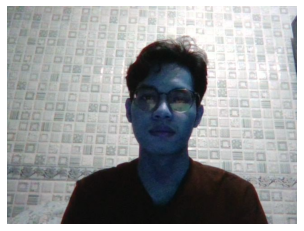

1/1 [==============================] - 0s 37ms/step
Diamond


In [ ]:
import cv2
import numpy as np

img = cv2.imread("/content/photo.jpg")
plt.axis("off");
plt.imshow(img)
plt.show()
img = cv2.resize(img,(200,200))
img = np.reshape(img,(1,200,200,3))
classes = model_cnn.predict(img)
# print(classes)
hasil = (np.argmax(classes))
print(classess[hasil])